# Final Project

##### Group 12:
Bader Albaarak, Ta Wei Lo, Shih-Wei Pan, Leela Bharani Teddu, Rose Hemans
##### Group Lead: 
Bader Albaarak

## Ask 1 - Search for a dataset

Our team decided to analyze English Premier League data for 21 Seasons between 1997/1998 to 2017/2018 for our final project. The dataset includes the date of games, referee, fixture name, home and away teams, and 21 different measured match events such as Points (Full Time), Corners Played, Shots, Shots on Target etc. The dataset size is 52.4 MB and has 335,160 records and 14 variables. It contains both text and numerical format to present the information.

We can download CSV file from (https://data.world/africananalyst/english-premier-league-data-for-20-seasons-to-20172018)

The data was gathered and cleaned by Ahmed Oyelowo using Microsoft Power Query ensuring the table is as slim as possible. So there is only one single field for "Values" which is described by another field called "Attribute" such as goals scored, corners conceded, yellow cards etc. This makes the data more organized for analysis.

To modify the dataset, we will use csvkit to conduct some preliminary analysis, remove additional columns and create a cleaner dataset which we will use the for the project.

First we will load SQL, create a new database, and retrieve the dataset from a public link where we downloaded the database to. The S3 bucket is open for anyone to download the dataset for to ensure reproducibility of this notebook.

#### Dataset Source

The dataset above represents the English Premier League, which is the highest level of professional soccer played in England. The dataset itself is derived from official data released the by Premier League. Additional statistics that are more player specific can be found from the Premier League website (https://www.premierleague.com/stats).

#### Why this dataset?



#### Setup SQL and create the final project database:

In [1]:
%load_ext sql

In [2]:
!dropdb -U student finalproject

In [3]:
!createdb -U student finalproject

In [4]:
%sql postgresql://student@/finalproject

#### Retrieve the dataset saved to an AWS S3 bucket:

In [5]:
!wget https://myhemansbucket.s3.amazonaws.com/EPL_20_Yrs_Data_1997_to_2018.csv

--2022-12-09 22:16:02--  https://myhemansbucket.s3.amazonaws.com/EPL_20_Yrs_Data_1997_to_2018.csv
Resolving myhemansbucket.s3.amazonaws.com (myhemansbucket.s3.amazonaws.com)... 52.216.53.89, 52.216.36.129, 3.5.1.122, ...
Connecting to myhemansbucket.s3.amazonaws.com (myhemansbucket.s3.amazonaws.com)|52.216.53.89|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 52410576 (50M) [text/csv]
Saving to: ‘EPL_20_Yrs_Data_1997_to_2018.csv’

EPL_20_Yrs_Data_199 100%[===================>]  49.98M  73.7MB/s    in 0.7s    

2022-12-09 22:16:03 (73.7 MB/s) - ‘EPL_20_Yrs_Data_1997_to_2018.csv’ saved [52410576/52410576]



In [6]:
!mv EPL_20_Yrs_Data_1997_to_2018.csv prem97to18.csv

#### Fix encoding, check column names and data head:

In [7]:
import pandas as pd
prem = pd.read_csv('prem97to18.csv',encoding='latin-1')
prem.columns

Index(['Date', 'Referee', 'Year', 'Month No', 'Month Name', 'Day',
       'Date for season', 'Fixture', 'Key', 'Season', 'Side', 'Team',
       'Attribute.1', 'Value'],
      dtype='object')

In [8]:
prem.head()

,Date,Referee,Year,Month No,Month Name,Day,Date for season,Fixture,Key,Season,Side,Team,Attribute.1,Value
0,26-Dec-98,NaN,1998,12,December,Saturday,26-Dec-98,Arsenal vs West Ham,26/12/1998Arsenal vs West Ham,1998 | 1999,HomeTeam,Arsenal,GA (Full Time),0
1,26-Dec-98,NaN,1998,12,December,Saturday,26-Dec-98,Arsenal vs West Ham,26/12/1998Arsenal vs West Ham,1998 | 1999,HomeTeam,Arsenal,GA (Half Time),0
2,26-Dec-98,NaN,1998,12,December,Saturday,26-Dec-98,Arsenal vs West Ham,26/12/1998Arsenal vs West Ham,1998 | 1999,HomeTeam,Arsenal,Total Shots,0
3,26-Dec-98,NaN,1998,12,December,Saturday,26-Dec-98,Arsenal vs West Ham,26/12/1998Arsenal vs West Ham,1998 | 1999,HomeTeam,Arsenal,Shots on target,0
4,26-Dec-98,NaN,1998,12,December,Saturday,26-Dec-98,Arsenal vs West Ham,26/12/1998Arsenal vs West Ham,1998 | 1999,HomeTeam,Arsenal,Fouls Committed,0


Now we will rename the columns so they are clear and related to the sport.

In [9]:
prem.columns = ['Date', 'Referee', 'Year', 'Month No', 'Month Name', 'Day',
       'Date for season', 'Fixture', 'Game id', 'Season', 'Side', 'Team',
       'match_event', 'match_event_count']

In [10]:
prem.head(1)

,Date,Referee,Year,Month No,Month Name,Day,Date for season,Fixture,Game id,Season,Side,Team,match_event,match_event_count
0,26-Dec-98,NaN,1998,12,December,Saturday,26-Dec-98,Arsenal vs West Ham,26/12/1998Arsenal vs West Ham,1998 | 1999,HomeTeam,Arsenal,GA (Full Time),0


#### Identify how many unique games there are to continue cleaning the dataset so game_id_key can be used as database's primary key:

In [11]:
prem_gameid = prem.groupby("Game id").count().index.tolist()

In [12]:
len(prem_gameid)

7980

#### There are 7980 unique games in the dataset. We will create a new dataframe using these unique games and corresponding data from the dataset by creating new columns for home and away count of attributes:

In [13]:
prem.to_csv(r'/home/ubuntu/notebooks/final_project/prem.csv',index=False, header=True)

In [14]:
!wc -l prem.csv

335161 prem.csv


In [15]:
!csvcut -n prem.csv

  1: Date
  2: Referee
  3: Year
  4: Month No
  5: Month Name
  6: Day
  7: Date for season
  8: Fixture
  9: Game id
 10: Season
 11: Side
 12: Team
 13: match_event
 14: match_event_count


In [16]:
!head -n 50000 prem.csv | csvstat

/home/ubuntu/.local/lib/python3.8/site-packages/agate/table/from_csv.py:74: RuntimeWarning: Error sniffing CSV dialect: Could not determine delimiter
  1. "Date"

	Type of data:          Text
	Contains null values:  False
	Unique values:         899
	Longest value:         9 characters
	Most common values:    14-May-00 (327x)
	                       26-Dec-98 (318x)
	                       10-May-98 (318x)
	                       16-May-99 (315x)
	                       26-Dec-97 (311x)

  2. "Referee"

	Type of data:          Text
	Contains null values:  True (excluded from calculations)
	Unique values:         107
	Longest value:         19 characters
	Most common values:    None (35742x)
	                       M Dean (866x)
	                       M Atkinson (616x)
	                       A Marriner (583x)
	                       L Mason (540x)

  3. "Year"

	Type of data:          Number
	Contains null values:  False
	Unique values:         22
	Smallest value:        1997
	Largest

In [17]:
from IPython.display import Image
Image(url="https://myhemansbucket.s3.amazonaws.com/finalprojectstarschema2.png")

#### Based on these values, we can expect to work with the following:

In [18]:
%%sql
DROP TABLE IF EXISTS games;

CREATE TABLE games (
    date TIMESTAMP NOT NULL,
    referee VARCHAR(64),
    year INTEGER NOT NULL,
    month_no INTEGER NOT NULL,
    month_name VARCHAR(64) NOT NULL,
    day VARCHAR(64) NOT NULL,
    date_for_season TIMESTAMP(64) NOT NULL,
    fixture VARCHAR(64) NOT NULL,
    game_id VARCHAR(64) NOT NULL,
    season CHAR(11) NOT NULL,
    side VARCHAR(64) NOT NULL,
    team VARCHAR(64) NOT NULL,
    match_event VARCHAR(64) NOT NULL,
    match_event_count INTEGER NOT NULL
)

 * postgresql://student@/finalproject
Done.
Done.


[]

In [19]:
!xsv search "18/08/2012Arsenal vs Sunderland" prem.csv| csvsort -c13 |xsv table

/home/ubuntu/.local/lib/python3.8/site-packages/agate/table/from_csv.py:74: RuntimeWarning: Error sniffing CSV dialect: Could not determine delimiter
Date       Referee  Year  Month No  Month Name  Day         Date for season  Fixture                Game id                          Season       Side      Team        match_event                 match_event_count
18-Aug-12  C Foy    2012  8         0001-08-01  0001-01-06  18-Aug-12        Arsenal vs Sunderland  18/08/2012Arsenal vs Sunderland  2012 | 2013  HomeTeam  Arsenal     Corners Conceded            0
18-Aug-12  C Foy    2012  8         0001-08-01  0001-01-06  18-Aug-12        Arsenal vs Sunderland  18/08/2012Arsenal vs Sunderland  2012 | 2013  AwayTeam  Sunderland  Corners Conceded            7
18-Aug-12  C Foy    2012  8         0001-08-01  0001-01-06  18-Aug-12        Arsenal vs Sunderland  18/08/2012Arsenal vs Sunderland  2012 | 2013  AwayTeam  Sunderland  Corners Played              0
18-Aug-12  C Foy    2012  8         0001-0

In [20]:
!xsv search "18/08/2012Arsenal vs Sunderland" prem.csv | xsv table | wc -l

43


In [21]:
!pwd

/home/ubuntu/notebooks/final_project


#### Now we are loading the data directly using the `COPY` command and looking at the games table in SQL:

In [22]:
%%sql
COPY games FROM '/home/ubuntu/notebooks/final_project/prem.csv'
CSV
HEADER;

 * postgresql://student@/finalproject
335160 rows affected.


[]

In [23]:
%%sql
SELECT COUNT(*) FROM games;

 * postgresql://student@/finalproject
1 rows affected.


count
335160


In [24]:
%%sql
SELECT * FROM games
LIMIT 10

 * postgresql://student@/finalproject
10 rows affected.


date,referee,year,month_no,month_name,day,date_for_season,fixture,game_id,season,side,team,match_event,match_event_count
1998-12-26 00:00:00,None,1998,12,December,Saturday,1998-12-26 00:00:00,Arsenal vs West Ham,26/12/1998Arsenal vs West Ham,1998 | 1999,HomeTeam,Arsenal,GA (Full Time),0
1998-12-26 00:00:00,None,1998,12,December,Saturday,1998-12-26 00:00:00,Arsenal vs West Ham,26/12/1998Arsenal vs West Ham,1998 | 1999,HomeTeam,Arsenal,GA (Half Time),0
1998-12-26 00:00:00,None,1998,12,December,Saturday,1998-12-26 00:00:00,Arsenal vs West Ham,26/12/1998Arsenal vs West Ham,1998 | 1999,HomeTeam,Arsenal,Total Shots,0
1998-12-26 00:00:00,None,1998,12,December,Saturday,1998-12-26 00:00:00,Arsenal vs West Ham,26/12/1998Arsenal vs West Ham,1998 | 1999,HomeTeam,Arsenal,Shots on target,0
1998-12-26 00:00:00,None,1998,12,December,Saturday,1998-12-26 00:00:00,Arsenal vs West Ham,26/12/1998Arsenal vs West Ham,1998 | 1999,HomeTeam,Arsenal,Fouls Committed,0
1998-12-26 00:00:00,None,1998,12,December,Saturday,1998-12-26 00:00:00,Arsenal vs West Ham,26/12/1998Arsenal vs West Ham,1998 | 1999,HomeTeam,Arsenal,Fouls Suffered,0
1998-12-26 00:00:00,None,1998,12,December,Saturday,1998-12-26 00:00:00,Arsenal vs West Ham,26/12/1998Arsenal vs West Ham,1998 | 1999,HomeTeam,Arsenal,Corners Played,0
1998-12-26 00:00:00,None,1998,12,December,Saturday,1998-12-26 00:00:00,Arsenal vs West Ham,26/12/1998Arsenal vs West Ham,1998 | 1999,HomeTeam,Arsenal,Corners Conceded,0
1998-12-26 00:00:00,None,1998,12,December,Saturday,1998-12-26 00:00:00,Arsenal vs West Ham,26/12/1998Arsenal vs West Ham,1998 | 1999,HomeTeam,Arsenal,Yellow Card (disadvantage),0
1998-12-26 00:00:00,None,1998,12,December,Saturday,1998-12-26 00:00:00,Arsenal vs West Ham,26/12/1998Arsenal vs West Ham,1998 | 1999,HomeTeam,Arsenal,Yellow Card (advantage),0


#### Our database will use game_id to identify unique games and enable us to work on analytics of games. We will look at distinct values for some columns:

In [25]:
%%sql
SELECT DISTINCT game_id
FROM games
ORDER BY game_id
LIMIT 10;

 * postgresql://student@/finalproject
10 rows affected.


game_id
01/01/2001Charlton vs Arsenal
01/01/2001Chelsea vs Aston Villa
01/01/2001Coventry vs Man City
01/01/2001Derby vs Everton
01/01/2001Leeds vs Middlesbrough
01/01/2001Leicester vs Bradford
01/01/2001Liverpool vs Southampton
01/01/2001Man United vs West Ham
01/01/2001Sunderland vs Ipswich
01/01/2002Charlton vs Ipswich


In [26]:
%%sql
SELECT DISTINCT season
FROM games
ORDER BY season;

 * postgresql://student@/finalproject
21 rows affected.


season
1997 | 1998
1998 | 1999
1999 | 2000
2000 | 2001
2001 | 2002
2002 | 2003
2003 | 2004
2004 | 2005
2005 | 2006
2006 | 2007


In [27]:
%%sql
SELECT DISTINCT date
FROM games
ORDER BY date
LIMIT 10;

 * postgresql://student@/finalproject
10 rows affected.


date
1997-08-09 00:00:00
1997-08-10 00:00:00
1997-08-11 00:00:00
1997-08-12 00:00:00
1997-08-13 00:00:00
1997-08-23 00:00:00
1997-08-24 00:00:00
1997-08-25 00:00:00
1997-08-26 00:00:00
1997-08-27 00:00:00


In [28]:
%%sql
SELECT DISTINCT date_for_season
FROM games
ORDER BY date_for_season
LIMIT 10;

 * postgresql://student@/finalproject
10 rows affected.


date_for_season
1997-08-09 00:00:00
1997-08-10 00:00:00
1997-08-11 00:00:00
1997-08-12 00:00:00
1997-08-13 00:00:00
1997-08-23 00:00:00
1997-08-24 00:00:00
1997-08-25 00:00:00
1997-08-26 00:00:00
1997-08-27 00:00:00


##### The columns date and date_for_season are identical. We will remove date_for_season. The columns for year, month, month_no, day, and month_name also will not improve our data analysis later on so we will remove them. Using just the date column, we can extract the day, month, and year of a game instead as more detailed time data:

In [29]:
%%sql
ALTER TABLE games
DROP COLUMN date_for_season,
DROP COLUMN year,
DROP COLUMN month_no,
DROP COLUMN day,
DROP COLUMN month_name;

 * postgresql://student@/finalproject
Done.


[]

We are creating the season, date, game, team dimensions, modifying fact, and linking it to the games table:

In [30]:
%%sql
DROP TABLE IF EXISTS season;

CREATE TABLE season (
    key SERIAL PRIMARY KEY,
    season_name CHAR(11)
);  

DROP TABLE IF EXISTS game;

CREATE TABLE game (
    key SERIAL PRIMARY KEY,
    game_id VARCHAR(64),
    fixture_name VARCHAR(64),
    referee VARCHAR(64)
);

DROP TABLE IF EXISTS team;

CREATE TABLE team (
    key SERIAL PRIMARY KEY,
    team_name VARCHAR(64)
);

DROP TABLE IF EXISTS side;

CREATE TABLE side (
    key SERIAL PRIMARY KEY,
    home_away VARCHAR(64)
);

DROP TABLE IF EXISTS match_events;

CREATE TABLE match_events (
    key SERIAL PRIMARY KEY,
    match_event VARCHAR(64)
);

 * postgresql://student@/finalproject
Done.
Done.
Done.
Done.
Done.
Done.
Done.
Done.
Done.
Done.


[]

In [31]:
%%sql
SELECT DISTINCT date,
    TO_CHAR(date, 'DD-MM-YYYY') AS day,
    TO_CHAR(date, 'MM-YYYY') AS month_of_year,
    TO_CHAR(date, 'YYYY') AS year
FROM games
LIMIT 10;

 * postgresql://student@/finalproject
10 rows affected.


date,day,month_of_year,year
2015-01-01 00:00:00,01-01-2015,01-2015,2015
2012-03-25 00:00:00,25-03-2012,03-2012,2012
2017-02-12 00:00:00,12-02-2017,02-2017,2017
2002-10-07 00:00:00,07-10-2002,10-2002,2002
2004-10-03 00:00:00,03-10-2004,10-2004,2004
2008-12-22 00:00:00,22-12-2008,12-2008,2008
2010-03-13 00:00:00,13-03-2010,03-2010,2010
2016-09-26 00:00:00,26-09-2016,09-2016,2016
1999-02-21 00:00:00,21-02-1999,02-1999,1999
2001-04-17 00:00:00,17-04-2001,04-2001,2001


In [32]:
%%sql
DROP TABLE IF EXISTS date;

CREATE TABLE date (
    key SERIAL PRIMARY KEY,
    date INTEGER,
    year INTEGER,
    month_of_year INTEGER,
    day INTEGER
);

 * postgresql://student@/finalproject
Done.
Done.


[]

In [33]:
%%sql
INSERT INTO date (day, month_of_year, year)
SELECT DISTINCT CAST(TO_CHAR(date, 'DD-MM-YYYY') AS INTEGER) AS day,
    CAST(TO_CHAR(date, 'MM-YYYY') AS INTEGER) AS month_of_year,
    CAST(TO_CHAR(date, 'YYYY') AS INTEGER) AS year
FROM games;

 * postgresql://student@/finalproject
(psycopg2.errors.InvalidTextRepresentation) invalid input syntax for type integer: "26-12-1998"

[SQL: INSERT INTO date (day, month_of_year, year)
SELECT DISTINCT CAST(TO_CHAR(date, 'DD-MM-YYYY') AS INTEGER) AS day,
    CAST(TO_CHAR(date, 'MM-YYYY') AS INTEGER) AS month_of_year,
    CAST(TO_CHAR(date, 'YYYY') AS INTEGER) AS year
FROM games;]
(Background on this error at: https://sqlalche.me/e/14/9h9h)


We are working on the team dimension table, inserting all unique teams from the dataset into the team dimension. Then we will add a home_team_key and away_team_key to the games fact table:

In [34]:
%%sql
SELECT * FROM team
LIMIT 10;

 * postgresql://student@/finalproject
0 rows affected.


key,team_name


In [35]:
%%sql
INSERT INTO team (team_name)
SELECT DISTINCT team AS team_name
FROM games;

 * postgresql://student@/finalproject
48 rows affected.


[]

In [36]:
%%sql
SELECT * FROM team
ORDER BY team_name
LIMIT 5;

 * postgresql://student@/finalproject
5 rows affected.


key,team_name
35,Arsenal
30,Aston Villa
45,Barnsley
3,Birmingham
46,Blackburn


In [37]:
%%sql
ALTER TABLE games
ADD COLUMN team_key INTEGER,
ADD CONSTRAINT fk_team
    FOREIGN KEY (team_key)
    REFERENCES team (key);

 * postgresql://student@/finalproject
Done.


[]

In [38]:
%%sql 
SELECT * FROM games LIMIT 1;

 * postgresql://student@/finalproject
1 rows affected.


date,referee,fixture,game_id,season,side,team,match_event,match_event_count,team_key
1998-12-26 00:00:00,None,Arsenal vs West Ham,26/12/1998Arsenal vs West Ham,1998 | 1999,HomeTeam,Arsenal,GA (Full Time),0,None


In [39]:
%%sql
UPDATE games
SET team_key = team.key
FROM team
WHERE games.team = team.team_name;

 * postgresql://student@/finalproject
335160 rows affected.


[]

In [40]:
%%sql
SELECT * FROM games
LIMIT 3;

 * postgresql://student@/finalproject
3 rows affected.


date,referee,fixture,game_id,season,side,team,match_event,match_event_count,team_key
1998-12-26 00:00:00,None,Newcastle vs Leeds,26/12/1998Newcastle vs Leeds,1998 | 1999,HomeTeam,Newcastle,GF(Full Time),0,28
1998-10-31 00:00:00,None,Newcastle vs West Ham,31/10/1998Newcastle vs West Ham,1998 | 1999,AwayTeam,West Ham,Shots Conceded,0,42
1998-10-24 00:00:00,None,Charlton vs West Ham,24/10/1998Charlton vs West Ham,1998 | 1999,AwayTeam,West Ham,GF (2nd Half),0,42


We are working on the side dimension table, where we will use the unique key and insert this into the games fact table. This will reference the 'side' in the game table.

In [41]:
%%sql
SELECT * FROM side
LIMIT 10;

 * postgresql://student@/finalproject
0 rows affected.


key,home_away


In [42]:
%%sql
INSERT INTO side (home_away)
SELECT DISTINCT side AS home_away
FROM games;

 * postgresql://student@/finalproject
2 rows affected.


[]

In [43]:
%%sql
SELECT * FROM side
ORDER BY home_away;

 * postgresql://student@/finalproject
2 rows affected.


key,home_away
2,AwayTeam
1,HomeTeam


In [44]:
%%sql
ALTER TABLE games
ADD COLUMN side_key INTEGER,
ADD CONSTRAINT fk_side
    FOREIGN KEY (side_key)
    REFERENCES side (key);

 * postgresql://student@/finalproject
Done.


[]

In [45]:
%%sql 
SELECT * FROM games LIMIT 1;

 * postgresql://student@/finalproject
1 rows affected.


date,referee,fixture,game_id,season,side,team,match_event,match_event_count,team_key,side_key
1998-10-24 00:00:00,None,Charlton vs West Ham,24/10/1998Charlton vs West Ham,1998 | 1999,AwayTeam,West Ham,GF (2nd Half),0,42,None


In [46]:
%%sql
UPDATE games
SET side_key = side.key
FROM side
WHERE games.side = side.home_away;

 * postgresql://student@/finalproject
335160 rows affected.


[]

In [47]:
%%sql
SELECT * FROM games
LIMIT 3;

 * postgresql://student@/finalproject
3 rows affected.


date,referee,fixture,game_id,season,side,team,match_event,match_event_count,team_key,side_key
1998-10-24 00:00:00,None,Charlton vs West Ham,24/10/1998Charlton vs West Ham,1998 | 1999,AwayTeam,West Ham,GF (2nd Half),0,42,2
1998-10-17 00:00:00,None,Chelsea vs Charlton,17/10/1998Chelsea vs Charlton,1998 | 1999,AwayTeam,Charlton,Fouls Committed,0,14,2
1998-11-14 00:00:00,None,Chelsea vs Wimbledon,14/11/1998Chelsea vs Wimbledon,1998 | 1999,HomeTeam,Chelsea,GA (Full Time),0,40,1


We are working on the match_events dimension table, where we will use the unique key and insert this into the games fact table. This will reference the 'match_event' in the game table.

In [48]:
%%sql
SELECT * FROM match_events
LIMIT 10;

 * postgresql://student@/finalproject
0 rows affected.


key,match_event


In [49]:
%%sql
INSERT INTO match_events (match_event)
SELECT DISTINCT match_event AS match_event
FROM games;

 * postgresql://student@/finalproject
21 rows affected.


[]

In [50]:
%%sql
SELECT * FROM match_events
ORDER BY match_event;

 * postgresql://student@/finalproject
21 rows affected.


key,match_event
19,Corners Conceded
4,Corners Played
11,Fouls Committed
10,Fouls Suffered
18,GA (2nd half)
8,GA (Full Time)
13,GA (Half Time)
5,GF (2nd Half)
20,GF(Full Time)
7,GF(Half Time)


In [51]:
%%sql
ALTER TABLE games
ADD COLUMN match_event_key INTEGER,
ADD CONSTRAINT fk_match_event
    FOREIGN KEY (match_event_key)
    REFERENCES match_events (key);

 * postgresql://student@/finalproject
Done.


[]

In [52]:
%%sql 
SELECT * FROM games LIMIT 1;

 * postgresql://student@/finalproject
1 rows affected.


date,referee,fixture,game_id,season,side,team,match_event,match_event_count,team_key,side_key,match_event_key
1998-11-14 00:00:00,None,Chelsea vs Wimbledon,14/11/1998Chelsea vs Wimbledon,1998 | 1999,HomeTeam,Chelsea,GA (Full Time),0,40,1,None


In [53]:
%%sql
UPDATE games
SET match_event_key = match_events.key
FROM match_events
WHERE games.match_event = match_events.match_event;

 * postgresql://student@/finalproject
335160 rows affected.


[]

In [54]:
%%sql
SELECT * FROM games
LIMIT 3;

 * postgresql://student@/finalproject
3 rows affected.


date,referee,fixture,game_id,season,side,team,match_event,match_event_count,team_key,side_key,match_event_key
1998-11-14 00:00:00,None,Chelsea vs Wimbledon,14/11/1998Chelsea vs Wimbledon,1998 | 1999,HomeTeam,Chelsea,GA (Full Time),0,40,1,8
1998-09-26 00:00:00,None,Everton vs Blackburn,26/09/1998Everton vs Blackburn,1998 | 1999,AwayTeam,Blackburn,GF (2nd Half),0,46,2,5
1998-09-26 00:00:00,None,Tottenham vs Leeds,26/09/1998Tottenham vs Leeds,1998 | 1999,AwayTeam,Leeds,Total Shots,0,2,2,6


We are working on the game dimension table, where we will use the unique key and insert this into the games fact table. This will reference the fixture and referee in the game table.

In [55]:
%%sql
SELECT * FROM game
LIMIT 3;

 * postgresql://student@/finalproject
0 rows affected.


key,game_id,fixture_name,referee


In [56]:
%%sql
INSERT INTO game (game_id)
SELECT DISTINCT game_id AS game_id
FROM games;

 * postgresql://student@/finalproject
7980 rows affected.


[]

In [57]:
%%sql
SELECT * FROM game
LIMIT 3;

 * postgresql://student@/finalproject
3 rows affected.


key,game_id,fixture_name,referee
1,26/10/2013Norwich vs Cardiff,None,None
2,22/02/2014Chelsea vs Everton,None,None
3,08/04/2017Stoke vs Liverpool,None,None


In [58]:
%%sql
UPDATE game
SET fixture_name = games.fixture
FROM games
WHERE game.game_id = games.game_id;

 * postgresql://student@/finalproject
7980 rows affected.


[]

In [59]:
%%sql
SELECT * FROM game
LIMIT 3;

 * postgresql://student@/finalproject
3 rows affected.


key,game_id,fixture_name,referee
6523,26/09/1998Everton vs Blackburn,Everton vs Blackburn,None
5731,26/09/1998Tottenham vs Leeds,Tottenham vs Leeds,None
3469,06/02/1999Chelsea vs Southampton,Chelsea vs Southampton,None


In [60]:
%%sql
UPDATE game
SET referee = games.referee
FROM games
WHERE game.game_id = games.game_id;

 * postgresql://student@/finalproject
7980 rows affected.


[]

In [61]:
%%sql
SELECT * FROM game
ORDER BY referee
LIMIT 3;

 * postgresql://student@/finalproject
3 rows affected.


key,game_id,fixture_name,referee
6105,28/12/2003Wolves vs Leeds,Wolves vs Leeds,A D'Urso
2025,15/12/2002Fulham vs Birmingham,Fulham vs Birmingham,A D'Urso
4050,09/03/2004Middlesbrough vs Tottenham,Middlesbrough vs Tottenham,A D'Urso


In [62]:
%%sql
SELECT DISTINCT referee
FROM game
ORDER BY referee
LIMIT 5;

 * postgresql://student@/finalproject
5 rows affected.


referee
A D'Urso
A Marriner
A Taylor
A Wiley
A. G. Wiley


In [63]:
%%sql
ALTER TABLE games
ADD COLUMN game_key INTEGER,
ADD CONSTRAINT fk_game_key
    FOREIGN KEY (game_key)
    REFERENCES game (key);

 * postgresql://student@/finalproject
Done.


[]

In [64]:
%%sql
SELECT * FROM games LIMIT 3;

 * postgresql://student@/finalproject
3 rows affected.


date,referee,fixture,game_id,season,side,team,match_event,match_event_count,team_key,side_key,match_event_key,game_key
1998-09-26 00:00:00,None,Everton vs Blackburn,26/09/1998Everton vs Blackburn,1998 | 1999,AwayTeam,Blackburn,GF (2nd Half),0,46,2,5,None
1998-09-26 00:00:00,None,Tottenham vs Leeds,26/09/1998Tottenham vs Leeds,1998 | 1999,AwayTeam,Leeds,Total Shots,0,2,2,6,None
1999-02-06 00:00:00,None,Chelsea vs Southampton,06/02/1999Chelsea vs Southampton,1998 | 1999,AwayTeam,Southampton,GF(Full Time),0,37,2,20,None


In [65]:
%%sql
UPDATE games
SET game_key = game.key
FROM game
WHERE games.game_id = game.game_id;

 * postgresql://student@/finalproject
335160 rows affected.


[]

In [66]:
%%sql
SELECT * FROM games LIMIT 3;

 * postgresql://student@/finalproject
3 rows affected.


date,referee,fixture,game_id,season,side,team,match_event,match_event_count,team_key,side_key,match_event_key,game_key
1999-02-06 00:00:00,None,Chelsea vs Southampton,06/02/1999Chelsea vs Southampton,1998 | 1999,AwayTeam,Southampton,GF(Full Time),0,37,2,20,3469
1999-02-06 00:00:00,None,Tottenham vs Coventry,06/02/1999Tottenham vs Coventry,1998 | 1999,HomeTeam,Tottenham,Shots Conceded on target,0,8,1,3,2565
1999-01-16 00:00:00,None,Nott'm Forest vs Arsenal,16/01/1999Nott'm Forest vs Arsenal,1998 | 1999,AwayTeam,Arsenal,GA (Full Time),0,35,2,8,4269


We are working on the season dimension table, inserting all unique seasons from the dataset into the season dimension. Then we will add a season_key games fact table:

In [67]:
%%sql
INSERT INTO season (season_name)
SELECT DISTINCT season AS season_name
FROM games;

 * postgresql://student@/finalproject
21 rows affected.


[]

In [68]:
%%sql
SELECT * FROM season
ORDER BY season_name;

 * postgresql://student@/finalproject
21 rows affected.


key,season_name
3,1997 | 1998
2,1998 | 1999
10,1999 | 2000
6,2000 | 2001
19,2001 | 2002
9,2002 | 2003
15,2003 | 2004
11,2004 | 2005
4,2005 | 2006
5,2006 | 2007


In [69]:
%%sql
ALTER TABLE games
ADD COLUMN season_key INTEGER,
ADD CONSTRAINT fk_season
    FOREIGN KEY (season_key)
    REFERENCES season (key);

 * postgresql://student@/finalproject
Done.


[]

In [70]:
%%sql
SELECT * FROM games LIMIT 3;

 * postgresql://student@/finalproject
3 rows affected.


date,referee,fixture,game_id,season,side,team,match_event,match_event_count,team_key,side_key,match_event_key,game_key,season_key
1999-02-06 00:00:00,None,Tottenham vs Coventry,06/02/1999Tottenham vs Coventry,1998 | 1999,HomeTeam,Tottenham,Shots Conceded on target,0,8,1,3,2565,None
1999-01-16 00:00:00,None,Nott'm Forest vs Arsenal,16/01/1999Nott'm Forest vs Arsenal,1998 | 1999,AwayTeam,Arsenal,GA (Full Time),0,35,2,8,4269,None
1999-01-16 00:00:00,None,Tottenham vs Wimbledon,16/01/1999Tottenham vs Wimbledon,1998 | 1999,HomeTeam,Tottenham,Shots Conceded,0,8,1,15,2868,None


In [71]:
%%sql
UPDATE games
SET season_key = season.key
FROM season
WHERE games.season = season.season_name;

 * postgresql://student@/finalproject
335160 rows affected.


[]

In [72]:
%%sql
SELECT * FROM games LIMIT 3;

 * postgresql://student@/finalproject
3 rows affected.


date,referee,fixture,game_id,season,side,team,match_event,match_event_count,team_key,side_key,match_event_key,game_key,season_key
1999-02-06 00:00:00,None,Tottenham vs Coventry,06/02/1999Tottenham vs Coventry,1998 | 1999,HomeTeam,Tottenham,Shots Conceded on target,0,8,1,3,2565,2
1999-01-16 00:00:00,None,Nott'm Forest vs Arsenal,16/01/1999Nott'm Forest vs Arsenal,1998 | 1999,AwayTeam,Arsenal,GA (Full Time),0,35,2,8,4269,2
1999-01-16 00:00:00,None,Tottenham vs Wimbledon,16/01/1999Tottenham vs Wimbledon,1998 | 1999,HomeTeam,Tottenham,Shots Conceded,0,8,1,15,2868,2


In [73]:
%%sql
SELECT * FROM games
ORDER BY game_key
LIMIT 1;

 * postgresql://student@/finalproject
1 rows affected.


date,referee,fixture,game_id,season,side,team,match_event,match_event_count,team_key,side_key,match_event_key,game_key,season_key
2013-10-26 00:00:00,M Jones,Norwich vs Cardiff,26/10/2013Norwich vs Cardiff,2013 | 2014,AwayTeam,Cardiff,GA (Full Time),0,12,2,8,1,12


In [74]:
%%sql
ALTER TABLE games
DROP COLUMN referee,
DROP COLUMN fixture,
DROP COLUMN game_id,
DROP COLUMN season,
DROP COLUMN side,
DROP COLUMN team,
DROP COLUMN match_event;

 * postgresql://student@/finalproject
Done.


[]

In [75]:
%%sql
SELECT * FROM games LIMIT 3;

 * postgresql://student@/finalproject
3 rows affected.


date,match_event_count,team_key,side_key,match_event_key,game_key,season_key
1999-02-06 00:00:00,0,8,1,3,2565,2
1999-01-16 00:00:00,0,35,2,8,4269,2
1999-01-16 00:00:00,0,8,1,15,2868,2


## Data Exploration - we are exploring some simple queries to explore the data through SQL:

In [76]:
%matplotlib inline

In [77]:
import matplotlib
matplotlib.use("Agg")
import matplotlib.pyplot as plt
import pandas as pd
import pickle

We will create a query to analyze the 2017 | 2018 league table by displaying the season, team, and total points earned:

In [78]:
%%sql
SELECT 
    s.season_name, t.team_name,
    sum(match_event_count) sum_points
FROM 
    Season S, Team T, Games G, Match_Events M
WHERE
    s.season_name = '2017 | 2018' and
    s.key = g.season_key and
    t.key = g.team_key and
    m.key = g.match_event_key and
    m.match_event = 'Points (Full Time)'
GROUP BY 
    s.season_name, t.team_name
ORDER BY s.season_name, sum_points DESC;

 * postgresql://student@/finalproject
20 rows affected.


season_name,team_name,sum_points
2017 | 2018,Man City,100
2017 | 2018,Man United,81
2017 | 2018,Tottenham,77
2017 | 2018,Liverpool,75
2017 | 2018,Chelsea,70
2017 | 2018,Arsenal,63
2017 | 2018,Burnley,54
2017 | 2018,Everton,49
2017 | 2018,Leicester,47
2017 | 2018,Newcastle,44


We will analyze the total number of red cards by season across the 20 seasons:

In [79]:
%%sql
SELECT 
    s.season_name,
    sum(match_event_count) total_red_cards
FROM 
    Season S, Match_Events M, Games G
WHERE
    s.key = g.season_key and
    m.key = g.match_event_key and
    m.match_event = 'Red Card (disadvantage)'
GROUP BY 
    s.season_name
ORDER BY s.season_name;

 * postgresql://student@/finalproject
21 rows affected.


season_name,total_red_cards
1997 | 1998,0
1998 | 1999,0
1999 | 2000,0
2000 | 2001,63
2001 | 2002,72
2002 | 2003,75
2003 | 2004,58
2004 | 2005,59
2005 | 2006,76
2006 | 2007,53


Here we can see there was most likely no data for red cards collected in the first three seasons even though in real life there were red cards given in these years. This is interesting to note. If we chose to analyze red cards in our business questions, we may select a shorter number of seasons than all available so the data is not skewed.

We will analyze the total points, total shots on target, and total shots conceded teams had in the most recent season available, '2017 | 2018':

In [80]:
%%sql
SELECT A.team_name, sum_points, sum_shots_on_target, sum_shots_conceded_on_target
FROM
(
SELECT t.team_name, 
    sum(match_event_count) sum_shots_on_target,
    count(1) as "count"
FROM Team T, Season S, Match_Events M, Games G
WHERE
    s.season_name = '2017 | 2018' and
    m.match_event = 'Shots on target' and
    s.key = g.season_key and
    t.key = g.team_key and
    m.key = g.match_event_key
GROUP BY t.team_name, g.match_event_key) as A,

(SELECT t.team_name,
    sum(match_event_count) sum_points,
    count(1) as "points"
FROM Team T, Season S, Match_Events M, Games G
WHERE
    s.season_name = '2017 | 2018' and
    m.match_event = 'Points (Full Time)' and
    s.key = g.season_key and
    t.key = g.team_key and
    m.key = g.match_event_key
GROUP BY t.team_name, g.match_event_key) as B,

(SELECT t.team_name,
    sum(match_event_count) sum_shots_conceded_on_target,
    count(1) as "shots conceded on target"
FROM Team T, Season S, Match_Events M, Games G
WHERE
    s.season_name = '2017 | 2018' and
    m.match_event = 'Shots Conceded on target' and
    s.key = g.season_key and
    t.key = g.team_key and
    m.key = g.match_event_key
GROUP BY t.team_name, g.match_event_key) as C
WHERE a.team_name=b.team_name and a.team_name=c.team_name
ORDER BY sum_points DESC;

 * postgresql://student@/finalproject
20 rows affected.


team_name,sum_points,sum_shots_on_target,sum_shots_conceded_on_target
Man City,100,261,87
Man United,81,181,146
Tottenham,77,217,126
Liverpool,75,233,103
Chelsea,70,220,120
Arsenal,63,233,148
Burnley,54,127,164
Everton,49,122,183
Leicester,47,148,168
Newcastle,44,150,157


Here we see there may be some correlation between points and attacking/defensive match events. This is something we can explore further 

We are exploring a similar query with more columns, now with corners played, and condceded, and yellows cards (advantage) and (disadvantage):

In [81]:
%%sql
SELECT A.team_name, sum_points, sum_shots_on_target, sum_shots_conceded_on_target, sum_corners_played, sum_corners_conceded, sum_yellow_cards_advantage, sum_yellow_cards_disadvantage
FROM
(
SELECT t.team_name, 
    sum(match_event_count) sum_shots_on_target,
    count(1) as "count"
FROM Team T, Season S, Match_Events M, Games G
WHERE
    s.season_name = '2017 | 2018' and
    m.match_event = 'Shots on target' and
    s.key = g.season_key and
    t.key = g.team_key and
    m.key = g.match_event_key
GROUP BY t.team_name, g.match_event_key) as A,

(SELECT t.team_name,
    sum(match_event_count) sum_points,
    count(1) as "points"
FROM Team T, Season S, Match_Events M, Games G
WHERE
    s.season_name = '2017 | 2018' and
    m.match_event = 'Points (Full Time)' and
    s.key = g.season_key and
    t.key = g.team_key and
    m.key = g.match_event_key
GROUP BY t.team_name, g.match_event_key) as B,

(SELECT t.team_name,
    sum(match_event_count) sum_shots_conceded_on_target,
    count(1) as "shots conceded on target"
FROM Team T, Season S, Match_Events M, Games G
WHERE
    s.season_name = '2017 | 2018' and
    m.match_event = 'Shots Conceded on target' and
    s.key = g.season_key and
    t.key = g.team_key and
    m.key = g.match_event_key
GROUP BY t.team_name, g.match_event_key) as C,

(SELECT t.team_name,
    sum(match_event_count) sum_corners_played,
    count(1) as "Corners played"
FROM Team T, Season S, Match_Events M, Games G
WHERE
    s.season_name = '2017 | 2018' and
    m.match_event = 'Corners Played' and
    s.key = g.season_key and
    t.key = g.team_key and
    m.key = g.match_event_key
GROUP BY t.team_name, g.match_event_key) as D,

(SELECT t.team_name,
    sum(match_event_count) sum_corners_conceded,
    count(1) as "Corners Conceded"
FROM Team T, Season S, Match_Events M, Games G
WHERE
    s.season_name = '2017 | 2018' and
    m.match_event = 'Corners Conceded' and
    s.key = g.season_key and
    t.key = g.team_key and
    m.key = g.match_event_key
GROUP BY t.team_name, g.match_event_key) as E,

(SELECT t.team_name,
    sum(match_event_count) sum_yellow_cards_advantage,
    count(1) as "Yellow Card (advantage)"
FROM Team T, Season S, Match_Events M, Games G
WHERE
    s.season_name = '2017 | 2018' and
    m.match_event = 'Yellow Card (advantage)' and
    s.key = g.season_key and
    t.key = g.team_key and
    m.key = g.match_event_key
GROUP BY t.team_name, g.match_event_key) as F,

(SELECT t.team_name,
    sum(match_event_count) sum_yellow_cards_disadvantage,
    count(1) as "Yellow Card (disadvantage)"
FROM Team T, Season S, Match_Events M, Games G
WHERE
    s.season_name = '2017 | 2018' and
    m.match_event = 'Yellow Card (disadvantage)' and
    s.key = g.season_key and
    t.key = g.team_key and
    m.key = g.match_event_key
GROUP BY t.team_name, g.match_event_key) as H
WHERE a.team_name=b.team_name and a.team_name=c.team_name and a.team_name=d.team_name and a.team_name = e.team_name and a.team_name = f.team_name and a.team_name = h.team_name
ORDER BY sum_points DESC;

 * postgresql://student@/finalproject
20 rows affected.


team_name,sum_points,sum_shots_on_target,sum_shots_conceded_on_target,sum_corners_played,sum_corners_conceded,sum_yellow_cards_advantage,sum_yellow_cards_disadvantage
Man City,100,261,87,284,103,76,58
Man United,81,181,146,220,175,68,64
Tottenham,77,217,126,246,160,75,49
Liverpool,75,233,103,230,126,49,44
Chelsea,70,220,120,230,159,73,41
Arsenal,63,233,148,223,179,48,57
Burnley,54,127,164,167,240,43,65
Everton,49,122,183,150,212,46,51
Leicester,47,148,168,203,216,52,52
Newcastle,44,150,157,167,223,62,52


# Ask 3: Data Analysis and Visualization

### Business Question 1:

Who is the best performing team (in terms of points) between the seasons 2007-2008 and 2017-2018? Do attacking attributes such as shots on target or defensive attributes shots conceded on target and goals allowed lead to higher points earned.

First, let's see who the best performing teams are in the past 10 years. We will explore individual seasons after.

In [82]:
%%sql
SELECT A.team_name, sum_points, season_2017_2018, season_2015_2016, season_2014_2015, season_2011_2012
FROM
(
SELECT t.team_name, 
    sum(match_event_count) sum_points,
    count(1) as "Total Points Over 10 Year Period"
FROM Team T, Season S, Match_Events M, Games G
WHERE
    m.match_event = 'Points (Full Time)' and
    NOT s.season_name = '1997 | 1998' and
    NOT s.season_name = '1998 | 1999' and    
    NOT s.season_name = '1999 | 2000' and
    NOT s.season_name = '2000 | 2001' and
    NOT s.season_name = '2001 | 2002' and
    NOT s.season_name = '2002 | 2003' and
    NOT s.season_name = '2003 | 2004' and
    NOT s.season_name = '2004 | 2005' and
    NOT s.season_name = '2005 | 2006' and
    NOT s.season_name = '2006 | 2007' and    
    s.key = g.season_key and
    t.key = g.team_key and
    m.key = g.match_event_key
GROUP BY t.team_name, g.match_event_key) as A,

(
SELECT t.team_name, 
    sum(match_event_count) season_2017_2018,
    count(1) as "Total Points for Season 2017-2018"
FROM Team T, Season S, Match_Events M, Games G
WHERE
    s.season_name = '2017 | 2018' and
    m.match_event = 'Points (Full Time)' and
    s.key = g.season_key and
    t.key = g.team_key and
    m.key = g.match_event_key
GROUP BY t.team_name, g.match_event_key) as B,

(
SELECT t.team_name, 
    sum(match_event_count) season_2015_2016,
    count(1) as "Total Points for Season 2015-2016"
FROM Team T, Season S, Match_Events M, Games G
WHERE
    s.season_name = '2015 | 2016' and
    m.match_event = 'Points (Full Time)' and
    s.key = g.season_key and
    t.key = g.team_key and
    m.key = g.match_event_key
GROUP BY t.team_name, g.match_event_key) as C,

(
SELECT t.team_name, 
    sum(match_event_count) season_2014_2015,
    count(1) as "Total Points for Season 2014-2015"
FROM Team T, Season S, Match_Events M, Games G
WHERE
    s.season_name = '2014 | 2015' and
    m.match_event = 'Points (Full Time)' and
    s.key = g.season_key and
    t.key = g.team_key and
    m.key = g.match_event_key
GROUP BY t.team_name, g.match_event_key) as D,

(
SELECT t.team_name, 
    sum(match_event_count) season_2011_2012,
    count(1) as "Total Points for Season 2014-2015"
FROM Team T, Season S, Match_Events M, Games G
WHERE
    s.season_name = '2011 | 2012' and
    m.match_event = 'Points (Full Time)' and
    s.key = g.season_key and
    t.key = g.team_key and
    m.key = g.match_event_key
GROUP BY t.team_name, g.match_event_key) as E
WHERE a.team_name=b.team_name and a.team_name=c.team_name and a.team_name=d.team_name and a.team_name=e.team_name 
ORDER BY sum_points DESC;

 * postgresql://student@/finalproject
11 rows affected.


team_name,sum_points,season_2017_2018,season_2015_2016,season_2014_2015,season_2011_2012
Man United,870,81,66,70,89
Chelsea,846,70,50,87,64
Man City,819,100,66,79,89
Arsenal,804,63,71,75,70
Liverpool,753,75,60,62,52
Tottenham,736,77,70,64,69
Everton,638,49,47,47,56
Stoke,457,33,51,54,45
Newcastle,398,44,37,39,65
West Brom,374,31,43,44,47


The best performing team in the past 10 years since 2018 is Man United, as they have accumulated 870 points, followed by Chelsea then Man City.

Let's test our hypothesis in the seasons 2017/2018, 2015/2016, and 2011/2012 to assess whether there is a correlation with higher points and certain attributes.

In [83]:
%%sql
SELECT t.team_name, 
    sum(match_event_count) season_2017_2018
FROM Team T, Season S, Match_Events M, Games G
WHERE
    s.season_name = '2017 | 2018' and
    m.match_event = 'Points (Full Time)' and
    s.key = g.season_key and
    t.key = g.team_key and
    m.key = g.match_event_key
GROUP BY t.team_name, g.match_event_key
ORDER BY season_2017_2018 DESC;

 * postgresql://student@/finalproject
20 rows affected.


team_name,season_2017_2018
Man City,100
Man United,81
Tottenham,77
Liverpool,75
Chelsea,70
Arsenal,63
Burnley,54
Everton,49
Leicester,47
Newcastle,44


In [84]:
%matplotlib inline

<BarContainer object of 20 artists>

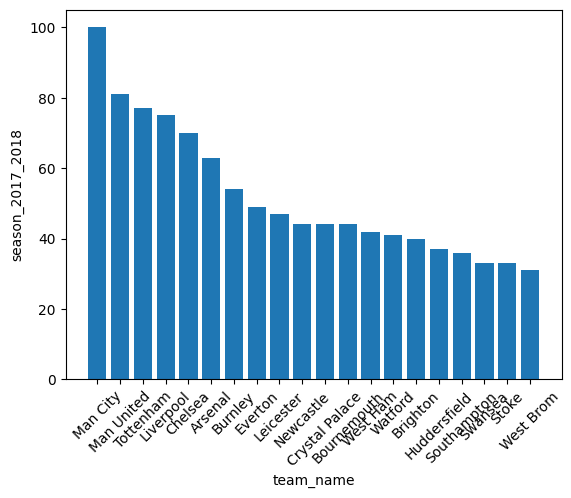

In [85]:
_.bar()

Lets explore shots on target for the same season:

In [86]:
%%sql
SELECT t.team_name, 
    sum(match_event_count) sum_shots_on_target
FROM Team T, Season S, Match_Events M, Games G
WHERE
    s.season_name = '2017 | 2018' and
    m.match_event = 'Shots on target' and
    s.key = g.season_key and
    t.key = g.team_key and
    m.key = g.match_event_key
GROUP BY t.team_name, g.match_event_key
ORDER BY sum_shots_on_target DESC;

 * postgresql://student@/finalproject
20 rows affected.


team_name,sum_shots_on_target
Man City,261
Arsenal,233
Liverpool,233
Chelsea,220
Tottenham,217
Man United,181
Bournemouth,157
Crystal Palace,151
Newcastle,150
Leicester,148


<BarContainer object of 20 artists>

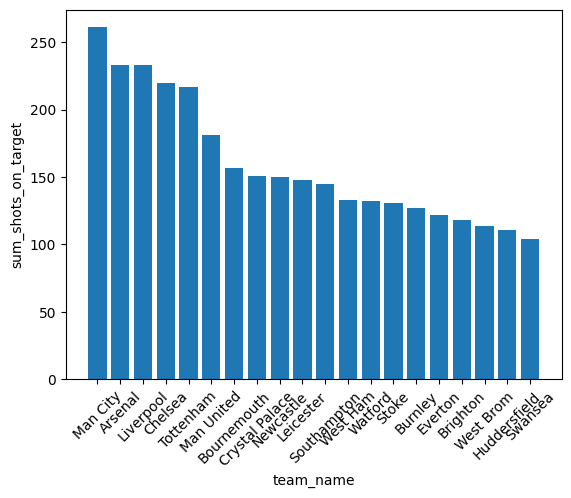

In [87]:
_.bar()

We see an identical trend of the bars in the graph above. Clearly, there is a correlation as Man City have had more shots on targets and also finished with the highest points. 

But we can also see that Man United rank 6th in terms of 'shots on target' but were the second highest team with points. So are there other attributes that resulted to this? Let's look at 'Shots Conceded On Target'.

In [88]:
%%sql
SELECT t.team_name, 
    sum(match_event_count) sum_shots_conceded_on_target
FROM Team T, Season S, Match_Events M, Games G
WHERE
    s.season_name = '2017 | 2018' and
    m.match_event = 'Shots Conceded on target' and
    s.key = g.season_key and
    t.key = g.team_key and
    m.key = g.match_event_key
GROUP BY t.team_name, g.match_event_key
ORDER BY sum_shots_conceded_on_target;

 * postgresql://student@/finalproject
20 rows affected.


team_name,sum_shots_conceded_on_target
Man City,87
Liverpool,103
Chelsea,120
Tottenham,126
Man United,146
Arsenal,148
West Brom,157
Newcastle,157
Watford,160
Burnley,164


<BarContainer object of 20 artists>

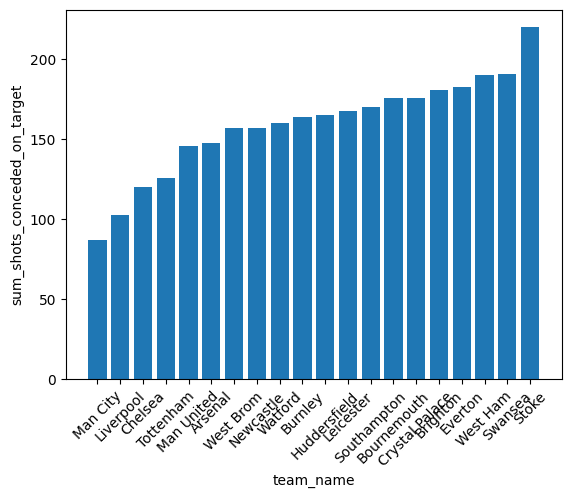

In [89]:
_.bar()

We can see an inverse trend here, since conceding more shots implies poorer defending. We can see that has led to few points as Brighton and Everton finished amongst the lowest in total points and highest in shots condeded on target.

Let's take a look at goals allowed next.

In [90]:
%%sql
SELECT t.team_name, 
    sum(match_event_count) sum_goals_allowed
FROM Team T, Season S, Match_Events M, Games G
WHERE
    s.season_name = '2017 | 2018' and
    m.match_event = 'GA (Full Time)' and
    s.key = g.season_key and
    t.key = g.team_key and
    m.key = g.match_event_key
GROUP BY t.team_name, g.match_event_key
ORDER BY sum_goals_allowed;

 * postgresql://student@/finalproject
20 rows affected.


team_name,sum_goals_allowed
Man City,27
Man United,28
Tottenham,36
Liverpool,38
Chelsea,38
Burnley,39
Newcastle,47
Arsenal,51
Brighton,54
Crystal Palace,55


<BarContainer object of 20 artists>

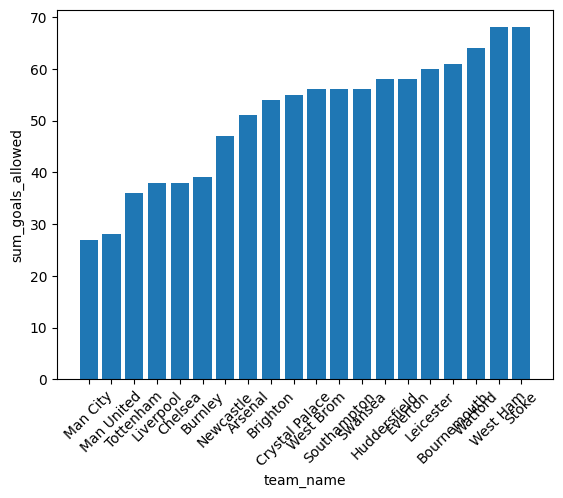

In [91]:
_.bar()

After running multiple analytical queries on the 2017-2018 season, we now know that while attacking is important so that the team gets higher points, but defense is the decisive factor. The better teams to defend, the better their chances of finishing in the top. Let's test our analysis in other seasons! 

### 2014-2015 Season

In [92]:
%%sql
SELECT t.team_name, 
    sum(match_event_count) season_2014_2015
FROM Team T, Season S, Match_Events M, Games G
WHERE
    s.season_name = '2014 | 2015' and
    m.match_event = 'Points (Full Time)' and
    s.key = g.season_key and
    t.key = g.team_key and
    m.key = g.match_event_key
GROUP BY t.team_name, g.match_event_key
ORDER BY season_2014_2015 DESC;

 * postgresql://student@/finalproject
20 rows affected.


team_name,season_2014_2015
Chelsea,87
Man City,79
Arsenal,75
Man United,70
Tottenham,64
Liverpool,62
Southampton,60
Swansea,56
Stoke,54
Crystal Palace,48


In [93]:
%matplotlib inline

<BarContainer object of 20 artists>

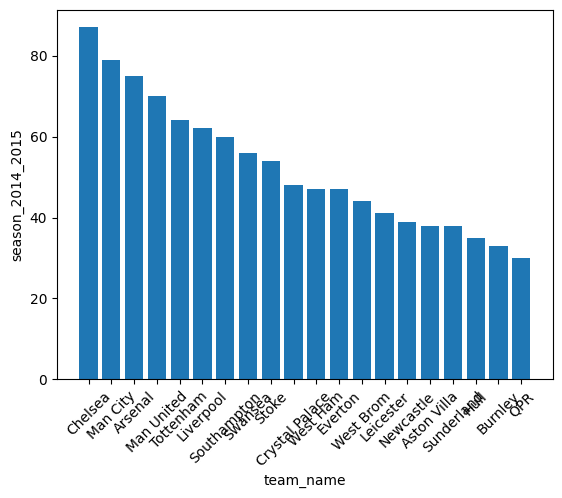

In [94]:
_.bar()

Lets explore shots on target for the same season:

In [95]:
%%sql
SELECT t.team_name, 
    sum(match_event_count) sum_shots_on_target
FROM Team T, Season S, Match_Events M, Games G
WHERE
    s.season_name = '2014 | 2015' and
    m.match_event = 'Shots on target' and
    s.key = g.season_key and
    t.key = g.team_key and
    m.key = g.match_event_key
GROUP BY t.team_name, g.match_event_key
ORDER BY sum_shots_on_target DESC;

 * postgresql://student@/finalproject
20 rows affected.


team_name,sum_shots_on_target
Arsenal,228
Man City,228
Chelsea,210
Liverpool,194
Man United,179
Tottenham,172
Southampton,170
Everton,166
West Ham,152
QPR,151


Chelsea had few shots on target, 210, than Arsenal and Man City, who both had 228 shots on target. Yet Chelsea finished top of the league with 87 points and Arsenal and Man City finished 3rd and 2nd, respectively. Lets look at defensive statistics like shots conceded on target.

In [96]:
%%sql
SELECT t.team_name, 
    sum(match_event_count) sum_shots_conceded_on_target
FROM Team T, Season S, Match_Events M, Games G
WHERE
    s.season_name = '2014 | 2015' and
    m.match_event = 'Shots Conceded on target' and
    s.key = g.season_key and
    t.key = g.team_key and
    m.key = g.match_event_key
GROUP BY t.team_name, g.match_event_key
ORDER BY sum_shots_conceded_on_target;

 * postgresql://student@/finalproject
20 rows affected.


team_name,sum_shots_conceded_on_target
Southampton,114
Chelsea,124
Everton,128
Man City,129
Arsenal,130
Man United,140
Stoke,143
Liverpool,143
Crystal Palace,151
Hull,157


<BarContainer object of 20 artists>

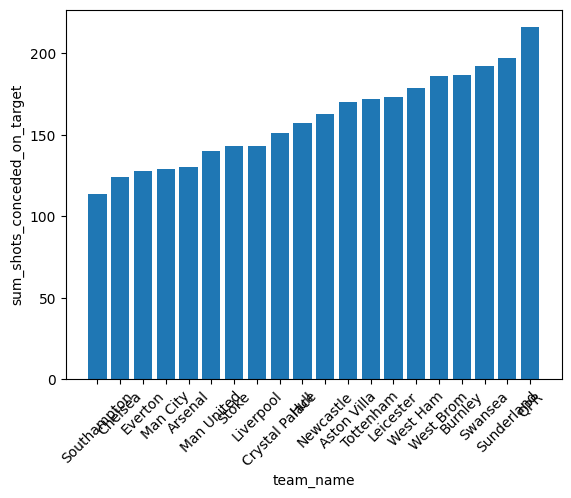

In [97]:
_.bar()

We can see an inverse trend here, since conceding more shots implies poorer defending. We can see that has led to few points as Brighton and Everton finished amongst the lowest in total points and highest in shots condeded on target.

Let's take a look at goals allowed next.

In [98]:
%%sql
SELECT t.team_name, 
    sum(match_event_count) sum_goals_allowed
FROM Team T, Season S, Match_Events M, Games G
WHERE
    s.season_name = '2014 | 2015' and
    m.match_event = 'GA (Full Time)' and
    s.key = g.season_key and
    t.key = g.team_key and
    m.key = g.match_event_key
GROUP BY t.team_name, g.match_event_key
ORDER BY sum_goals_allowed;

 * postgresql://student@/finalproject
20 rows affected.


team_name,sum_goals_allowed
Chelsea,32
Southampton,33
Arsenal,36
Man United,37
Man City,38
Stoke,45
West Ham,47
Liverpool,48
Swansea,49
Everton,50


<BarContainer object of 20 artists>

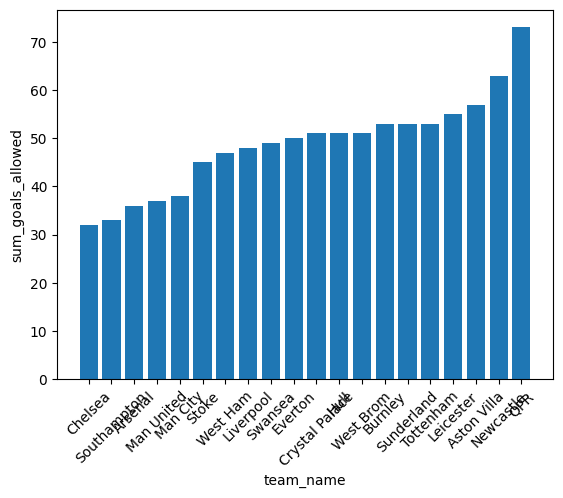

In [99]:
_.bar()

It looks like our preliminary analysis is holding up! The better you defend, the higher your chances to finish in the top.

### 2011-2012 Season

In [100]:
%%sql
SELECT t.team_name, 
    sum(match_event_count) season_2011_2012
FROM Team T, Season S, Match_Events M, Games G
WHERE
    s.season_name = '2011 | 2012' and
    m.match_event = 'Points (Full Time)' and
    s.key = g.season_key and
    t.key = g.team_key and
    m.key = g.match_event_key
GROUP BY t.team_name, g.match_event_key
ORDER BY season_2011_2012 DESC;

 * postgresql://student@/finalproject
20 rows affected.


team_name,season_2011_2012
Man City,89
Man United,89
Arsenal,70
Tottenham,69
Newcastle,65
Chelsea,64
Everton,56
Fulham,52
Liverpool,52
Swansea,47


<BarContainer object of 20 artists>

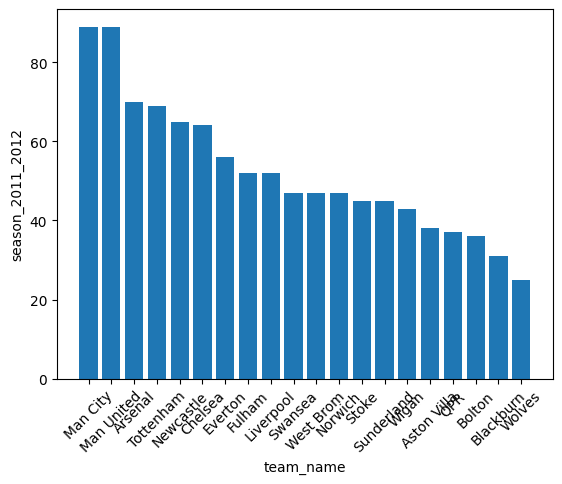

In [101]:
_.bar()

Lets explore shots on target for the same season:

In [102]:
%%sql
SELECT t.team_name, 
    sum(match_event_count) sum_shots_on_target
FROM Team T, Season S, Match_Events M, Games G
WHERE
    s.season_name = '2011 | 2012' and
    m.match_event = 'Shots on target' and
    s.key = g.season_key and
    t.key = g.team_key and
    m.key = g.match_event_key
GROUP BY t.team_name, g.match_event_key
ORDER BY sum_shots_on_target DESC;

 * postgresql://student@/finalproject
20 rows affected.


team_name,sum_shots_on_target
Man City,399
Tottenham,373
Man United,369
Arsenal,352
Chelsea,334
Liverpool,330
Fulham,301
Bolton,275
West Brom,264
QPR,264


<BarContainer object of 20 artists>

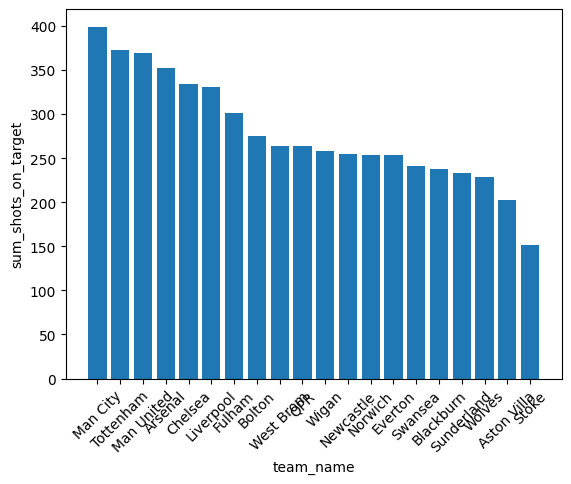

In [103]:
_.bar()

In [104]:
%%sql
SELECT t.team_name, 
    sum(match_event_count) sum_shots_conceded_on_target
FROM Team T, Season S, Match_Events M, Games G
WHERE
    s.season_name = '2011 | 2012' and
    m.match_event = 'Shots Conceded on target' and
    s.key = g.season_key and
    t.key = g.team_key and
    m.key = g.match_event_key
GROUP BY t.team_name, g.match_event_key
ORDER BY sum_shots_conceded_on_target;

 * postgresql://student@/finalproject
20 rows affected.


team_name,sum_shots_conceded_on_target
Arsenal,197
Liverpool,199
Man City,204
Everton,227
Chelsea,241
Tottenham,252
Man United,263
Newcastle,276
Wigan,278
West Brom,281


<BarContainer object of 20 artists>

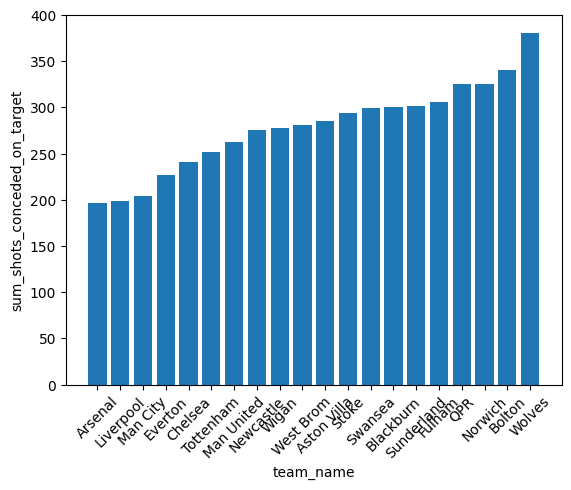

In [105]:
_.bar()

In [106]:
%%sql
SELECT t.team_name, 
    sum(match_event_count) sum_goals_allowed
FROM Team T, Season S, Match_Events M, Games G
WHERE
    s.season_name = '2011 | 2012' and
    m.match_event = 'GA (Full Time)' and
    s.key = g.season_key and
    t.key = g.team_key and
    m.key = g.match_event_key
GROUP BY t.team_name, g.match_event_key
ORDER BY sum_goals_allowed;

 * postgresql://student@/finalproject
20 rows affected.


team_name,sum_goals_allowed
Man City,29
Man United,33
Liverpool,40
Everton,40
Tottenham,41
Chelsea,46
Sunderland,46
Arsenal,49
Newcastle,51
Fulham,51


<BarContainer object of 20 artists>

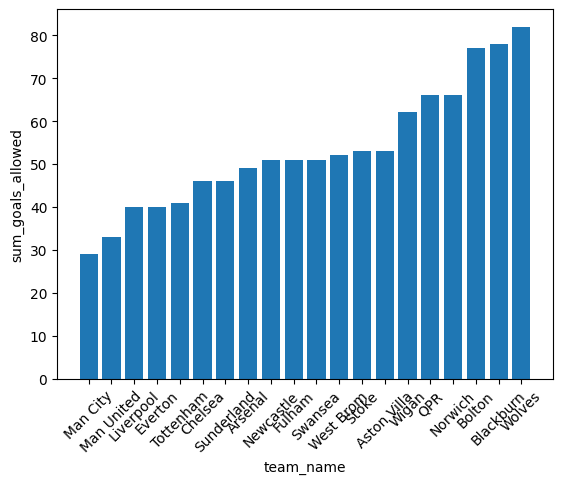

In [107]:
_.bar()

##### Finally, after conducting the analysis on the 2011-2021 season, the data shows that defense is the decisive factor in finishing the season with the high points. However, while the data also shows that defense is the most crucial factor, but to finish in the top, you have to also perform highly on the attack.

### Business Question 2:

This part is intended to help coaches and players be cautious of certain referees and manage the performance better. We want to identify who is the strict referees first and next identify the red card & yellow card issued over the time. 
The specific questions are: 
* Who are the top 10 strictest Premier League referees between 2015-2016 and 2017-2018? 
* Are the number of yellow cards issued trending up or down since 2001?
* Are the number of red cards issued trending up or down since 2001?
* Season with yellow card and red card

First, we want to identify who are strict referees from 2015-2017 season in terms of red cards & yellow cards. So, we sum up the red cards and yellow cards of each referees. After that, rank these two columns descendingly. 

In [108]:
%%sql
SELECT A.referee, sum_yellow_cards, sum_red_cards
FROM
(
SELECT r.referee, 
    sum(match_event_count) sum_yellow_cards,
    count(1) as "Total Yellow Cards"
FROM Game R, Season S, Match_Events M, Games G
WHERE
    m.match_event = 'Yellow Card (disadvantage)' and
    NOT s.season_name = '1997 | 1998' and
    NOT s.season_name = '1998 | 1999' and    
    NOT s.season_name = '1999 | 2000' and
    NOT s.season_name = '2000 | 2001' and
    NOT s.season_name = '2001 | 2002' and
    NOT s.season_name = '2002 | 2003' and
    NOT s.season_name = '2003 | 2004' and
    NOT s.season_name = '2004 | 2005' and
    NOT s.season_name = '2005 | 2006' and
    NOT s.season_name = '2006 | 2007' and
    NOT s.season_name = '2007 | 2008' and
    NOT s.season_name = '2008 | 2009' and
    NOT s.season_name = '2009 | 2010' and    
    NOT s.season_name = '2010 | 2011' and
    NOT s.season_name = '2011 | 2012' and
    NOT s.season_name = '2012 | 2013' and
    NOT s.season_name = '2013 | 2014' and
    NOT s.season_name = '2014 | 2015' and
    s.key = g.season_key and
    r.key = g.game_key and
    m.key = g.match_event_key
GROUP BY r.referee, g.match_event_key) as A,

(
SELECT r.referee, 
    sum(match_event_count) sum_red_cards,
    count(1) as "Total Yellow Cards"
FROM Game R, Season S, Match_Events M, Games G
WHERE
    m.match_event = 'Red Card (disadvantage)' and
    NOT s.season_name = '1997 | 1998' and
    NOT s.season_name = '1998 | 1999' and    
    NOT s.season_name = '1999 | 2000' and
    NOT s.season_name = '2000 | 2001' and
    NOT s.season_name = '2001 | 2002' and
    NOT s.season_name = '2002 | 2003' and
    NOT s.season_name = '2003 | 2004' and
    NOT s.season_name = '2004 | 2005' and
    NOT s.season_name = '2005 | 2006' and
    NOT s.season_name = '2006 | 2007' and
    NOT s.season_name = '2007 | 2008' and
    NOT s.season_name = '2008 | 2009' and
    NOT s.season_name = '2009 | 2010' and    
    NOT s.season_name = '2010 | 2011' and
    NOT s.season_name = '2011 | 2012' and
    NOT s.season_name = '2012 | 2013' and
    NOT s.season_name = '2013 | 2014' and
    NOT s.season_name = '2014 | 2015' and
    s.key = g.season_key and
    r.key = g.game_key and
    m.key = g.match_event_key
GROUP BY r.referee, g.match_event_key) as B
WHERE a.referee=b.referee
ORDER BY sum_red_cards DESC, sum_yellow_cards DESC
LIMIT 10;

 * postgresql://student@/finalproject
10 rows affected.


referee,sum_yellow_cards,sum_red_cards
M Dean,309,17
M Oliver,296,13
J Moss,296,11
A Taylor,318,10
C Pawson,262,10
A Marriner,256,10
M Atkinson,288,9
R Madley,245,9
M Clattenburg,167,9
L Mason,171,8


Consider both yellow and red cards issues, the top 5 strict referees are M Dean, M Oliver, J Moss, A Taylor, and C Pawson. If the referees have the same yellow cards, the code use red card number to rank and make the sequence. When playing against these referees, players need to be careful and avoid the disadvantages. 

Next step, we seperated two cards. This part, we identify which referee issued the most yellow cards from 2015-2017 season. Appying the the same method, sum up the yellow cards of each referee and rank by the number of yellow cards.

In [109]:
%%sql
SELECT r.referee,
    sum(match_event_count) sum_yellow_cards
FROM Game R, Season S, Match_Events M, Games G
WHERE
    NOT s.season_name = '1997 | 1998' and
    NOT s.season_name = '1998 | 1999' and    
    NOT s.season_name = '1999 | 2000' and
    NOT s.season_name = '2000 | 2001' and
    NOT s.season_name = '2001 | 2002' and
    NOT s.season_name = '2002 | 2003' and
    NOT s.season_name = '2003 | 2004' and
    NOT s.season_name = '2004 | 2005' and
    NOT s.season_name = '2005 | 2006' and
    NOT s.season_name = '2006 | 2007' and
    NOT s.season_name = '2007 | 2008' and
    NOT s.season_name = '2008 | 2009' and
    NOT s.season_name = '2009 | 2010' and    
    NOT s.season_name = '2010 | 2011' and
    NOT s.season_name = '2011 | 2012' and
    NOT s.season_name = '2012 | 2013' and
    NOT s.season_name = '2013 | 2014' and
    NOT s.season_name = '2014 | 2015' and
    m.match_event = 'Yellow Card (disadvantage)' and
    s.key = g.season_key and
    r.key = g.game_key and
    m.key = g.match_event_key
GROUP BY r.referee, g.match_event_key
ORDER BY sum_yellow_cards DESC
LIMIT 10;

 * postgresql://student@/finalproject
10 rows affected.


referee,sum_yellow_cards
A Taylor,318
M Dean,309
J Moss,296
M Oliver,296
M Atkinson,288
C Pawson,262
A Marriner,256
R Madley,245
K Friend,199
N Swarbrick,197


<BarContainer object of 10 artists>

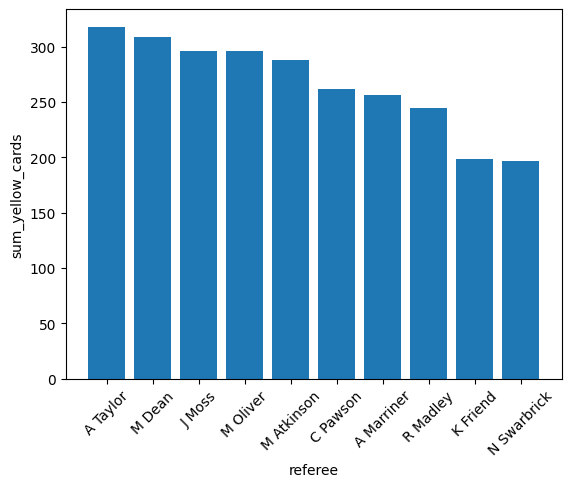

In [110]:
_.bar()

In terms of the yellow card issued, A Taylor issued more than other referees (318). Following, M Dean is the second and the J Moss the third. These are the top three referees who issue more yellow cards. Thus, player can be aware of them in advance. 

Furthermore, we want to identify which referee issued more red cards. The method is similar: sum up the red cards of each referee and rank the number descendingly.  

In [111]:
%%sql
SELECT r.referee,
    sum(match_event_count) sum_red_cards
FROM Game R, Season S, Match_Events M, Games G
WHERE
    NOT s.season_name = '1997 | 1998' and
    NOT s.season_name = '1998 | 1999' and    
    NOT s.season_name = '1999 | 2000' and
    NOT s.season_name = '2000 | 2001' and
    NOT s.season_name = '2001 | 2002' and
    NOT s.season_name = '2002 | 2003' and
    NOT s.season_name = '2003 | 2004' and
    NOT s.season_name = '2004 | 2005' and
    NOT s.season_name = '2005 | 2006' and
    NOT s.season_name = '2006 | 2007' and
    NOT s.season_name = '2007 | 2008' and
    NOT s.season_name = '2008 | 2009' and
    NOT s.season_name = '2009 | 2010' and    
    NOT s.season_name = '2010 | 2011' and
    NOT s.season_name = '2011 | 2012' and
    NOT s.season_name = '2012 | 2013' and
    NOT s.season_name = '2013 | 2014' and
    NOT s.season_name = '2014 | 2015' and
    m.match_event = 'Red Card (disadvantage)' and
    s.key = g.season_key and
    r.key = g.game_key and
    m.key = g.match_event_key
GROUP BY r.referee, g.match_event_key
ORDER BY sum_red_cards DESC
LIMIT 10;

 * postgresql://student@/finalproject
10 rows affected.


referee,sum_red_cards
M Dean,17
M Oliver,13
J Moss,11
A Marriner,10
A Taylor,10
C Pawson,10
M Atkinson,9
M Clattenburg,9
R Madley,9
L Mason,8


In terms of the red card issued, M Dean issued more than other referees (17). Following, M Oliver is the second the J Moss is the third. We notice that M Dean issued more red ticks than the other referees. Apparenly, team players need to be more causious under his watches.

<BarContainer object of 10 artists>

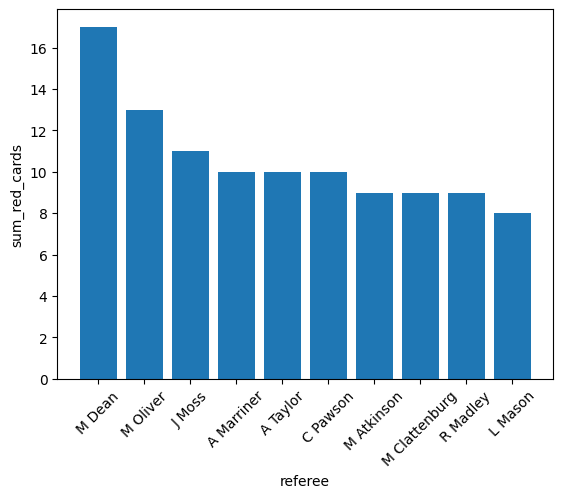

In [112]:
_.bar()

#### Yellow Cards issued after between 2001-2002 and 2017-2018

We want to study whether the game is playing more competitive as times go by. The way to get the result is by filter the time from 2001-2017, and sum up the yellow cards by each season, and order by the season.

In [124]:
%%sql
SELECT s.season_name,
    sum(match_event_count) sum_yellow_cards
FROM Game R, Season S, Match_Events M, Games G
WHERE
    NOT s.season_name = '1997 | 1998' and
    NOT s.season_name = '1998 | 1999' and    
    NOT s.season_name = '1999 | 2000' and
    NOT s.season_name = '2000 | 2001' and
    m.match_event = 'Yellow Card (disadvantage)' and
    s.key = g.season_key and
    r.key = g.game_key and
    m.key = g.match_event_key
GROUP BY s.season_name, g.match_event_key
ORDER BY season_name;

 * postgresql://student@/finalproject
17 rows affected.


season_name,sum_yellow_cards
2001 | 2002,1165
2002 | 2003,1142
2003 | 2004,1081
2004 | 2005,1031
2005 | 2006,1173
2006 | 2007,1225
2007 | 2008,1216
2008 | 2009,1198
2009 | 2010,1237
2010 | 2011,1236


<BarContainer object of 17 artists>

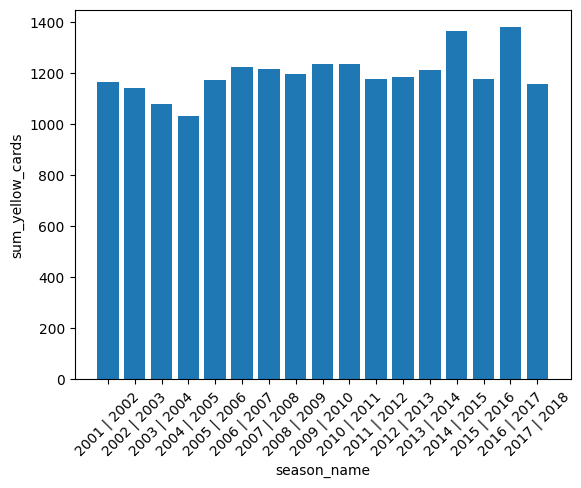

In [125]:
_.bar()

It seems that yellow cards issued aren’t related with time: there is a up and down with time but no clear trend. From 2001 to 2004 season, the number decreases a bit. From 2004-2017, most of the yellow cards issued are around 1200 yellow cards issued. Only 2014 and 2016 season have higher numbers that does not fit into the trend.  

## Red Cards issued after between 2001-2002 and 2017-2018

Next, we wan to study the red card issued with time. Still use the same method to filter, combine and rank to data.

In [114]:
%%sql
SELECT s.season_name,
    sum(match_event_count) sum_red_cards
FROM Game R, Season S, Match_Events M, Games G
WHERE
    NOT s.season_name = '1997 | 1998' and
    NOT s.season_name = '1998 | 1999' and    
    NOT s.season_name = '1999 | 2000' and
    NOT s.season_name = '2000 | 2001' and
    m.match_event = 'Red Card (disadvantage)' and
    s.key = g.season_key and
    r.key = g.game_key and
    m.key = g.match_event_key
GROUP BY s.season_name, g.match_event_key
ORDER BY season_name;

 * postgresql://student@/finalproject
17 rows affected.


season_name,sum_red_cards
2001 | 2002,72
2002 | 2003,75
2003 | 2004,58
2004 | 2005,59
2005 | 2006,76
2006 | 2007,53
2007 | 2008,61
2008 | 2009,63
2009 | 2010,68
2010 | 2011,63


<BarContainer object of 17 artists>

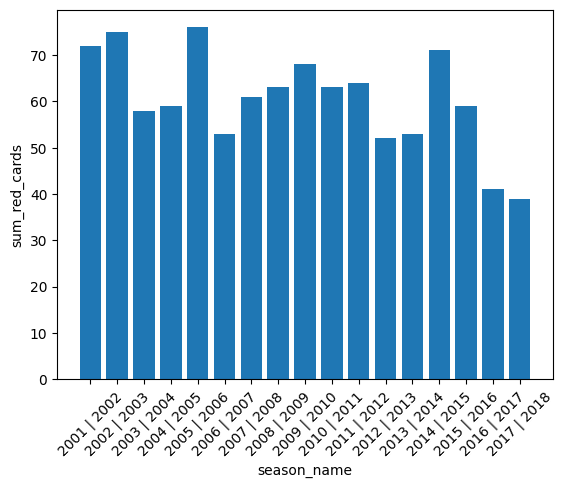

In [115]:
_.bar()

However, with time goes by, red cards issued have an overall decreasing trend. Some seasons have higher red cards issue, such as 2005 and 2014.
With these insights, coaches can focus on red cards management and so avoid the unfavorable situations.  

#### Side-by-side comparison of yellow cards and red cards issued after between 2001-2002 and 2017-2018

In [130]:
%%sql
SELECT A.season_name, sum_yellow_cards, sum_red_cards
FROM
(
SELECT s.season_name, 
    sum(match_event_count) sum_yellow_cards,
    count(1) as "Total Yellow Cards"
FROM Game R, Season S, Match_Events M, Games G
WHERE
    m.match_event = 'Yellow Card (disadvantage)' and
    NOT s.season_name = '1997 | 1998' and
    NOT s.season_name = '1998 | 1999' and    
    NOT s.season_name = '1999 | 2000' and
    NOT s.season_name = '2000 | 2001' and
    s.key = g.season_key and
    r.key = g.game_key and
    m.key = g.match_event_key
GROUP BY s.season_name, g.match_event_key) as A,

(
SELECT s.season_name, 
    sum(match_event_count) sum_red_cards,
    count(1) as "Total Yellow Cards"
FROM Game R, Season S, Match_Events M, Games G
WHERE
    m.match_event = 'Red Card (disadvantage)' and
    NOT s.season_name = '1997 | 1998' and
    NOT s.season_name = '1998 | 1999' and    
    NOT s.season_name = '1999 | 2000' and
    NOT s.season_name = '2000 | 2001' and
    s.key = g.season_key and
    r.key = g.game_key and
    m.key = g.match_event_key
GROUP BY s.season_name, g.match_event_key) as B
WHERE a.season_name=b.season_name
ORDER BY season_name;

 * postgresql://student@/finalproject
17 rows affected.


season_name,sum_yellow_cards,sum_red_cards
2001 | 2002,1165,72
2002 | 2003,1142,75
2003 | 2004,1081,58
2004 | 2005,1031,59
2005 | 2006,1173,76
2006 | 2007,1225,53
2007 | 2008,1216,61
2008 | 2009,1198,63
2009 | 2010,1237,68
2010 | 2011,1236,63


In the the table, we can compare time yellow cards and red cards together. Coaches will be interested in these tow data combined together. 

### Business Question 3:

What is the total points earned by teams across the 21 seasons recorded? Do corner kicks affect the number of points earned? What is the relationship between these two variables?

To analyze whether corner kicks gives an advantage to teams, below we will create a table to display total points and toal corners played for all teams across the 21 seasons:

In [117]:
%%sql
SELECT A.team_name, sum_points, sum_corners_played
FROM
(
SELECT t.team_name, 
    sum(match_event_count) sum_points,
    count(1) as "count"
FROM Team T, Season S, Match_Events M, Games G
WHERE
    m.match_event = 'Points (Full Time)' and
    s.key = g.season_key and
    t.key = g.team_key and
    m.key = g.match_event_key
GROUP BY t.team_name, g.match_event_key) as A,

(SELECT t.team_name,
    sum(match_event_count) sum_corners_played,
    count(1) as "points"
FROM Team T, Season S, Match_Events M, Games G
WHERE
    m.match_event = 'Corners Played' and
    s.key = g.season_key and
    t.key = g.team_key and
    m.key = g.match_event_key
GROUP BY t.team_name, g.match_event_key) as B
WHERE a.team_name=b.team_name
ORDER BY sum_points DESC;

 * postgresql://student@/finalproject
48 rows affected.


team_name,sum_points,sum_corners_played
Man United,1681,4440
Chelsea,1589,4250
Arsenal,1576,4381
Liverpool,1420,4400
Tottenham,1251,4111
Everton,1123,3831
Man City,1082,4065
Newcastle,932,3269
Aston Villa,920,3401
West Ham,851,2998


<BarContainer object of 48 artists>

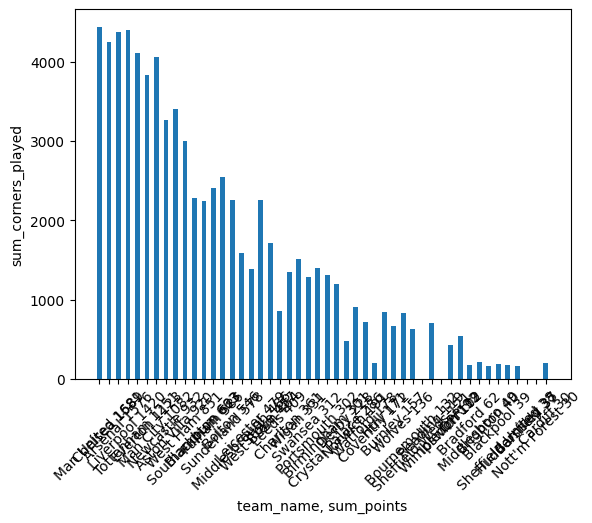

In [118]:
_.bar(width = 0.5)

From the bar chart, we can see in general the more corners played, the more points earned across the 20 seasons. However we can see that some teams did not benefit from this correlation in the way that the majority did. 

For example, West Brom had 2255 corners played across the 21 seasons but only earned 464 points from games in this time period. To compare, Blackburn had a similar number of corners played, 2242, but earned 623 points.

We can also look at Man City who had 4065 corners played, the 6th most out of all teams, and earned 1082 points, 7th most. Everton, on the other hand, had 3831 corners played, less than Man City, and 1123 total points, more than City overall.

We would like to conduct similar analysis but focusing on the disadvantage of conceding corners and what effect this has on points earned. We will select all 21 seasons.

In [119]:
%%sql
SELECT A.team_name, sum_points, sum_corners_conceded
FROM
(
SELECT t.team_name, 
    sum(match_event_count) sum_points,
    count(1) as "count"
FROM Team T, Season S, Match_Events M, Games G
WHERE
    m.match_event = 'Points (Full Time)' and
    s.key = g.season_key and
    t.key = g.team_key and
    m.key = g.match_event_key
GROUP BY t.team_name, g.match_event_key) as A,

(SELECT t.team_name,
    sum(match_event_count) sum_corners_conceded,
    count(1) as "corners conceded"
FROM Team T, Season S, Match_Events M, Games G
WHERE
    m.match_event = 'Corners Conceded' and
    s.key = g.season_key and
    t.key = g.team_key and
    m.key = g.match_event_key
GROUP BY t.team_name, g.match_event_key) as B
WHERE a.team_name=b.team_name
ORDER BY sum_points DESC;

 * postgresql://student@/finalproject
48 rows affected.


team_name,sum_points,sum_corners_conceded
Man United,1681,2840
Chelsea,1589,3011
Arsenal,1576,3050
Liverpool,1420,2896
Tottenham,1251,3601
Everton,1123,3733
Man City,1082,3150
Newcastle,932,3205
Aston Villa,920,3637
West Ham,851,3413


<BarContainer object of 48 artists>

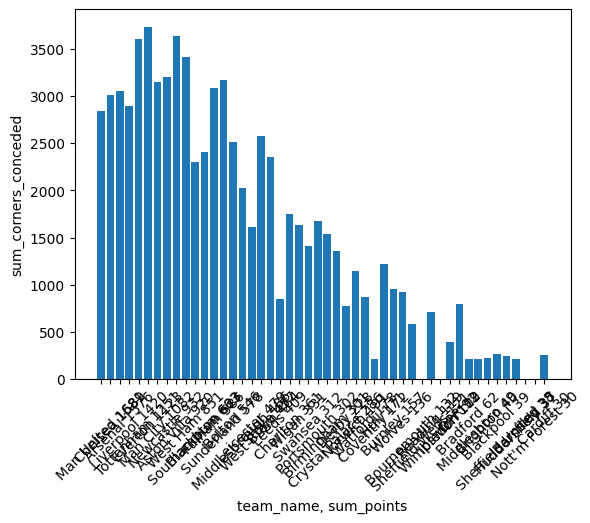

In [120]:
_.bar()

From the bar chart, interestingly, we can see the 4 teams with the highest total points, had lower corners conceded than other teams such as Tottenham and Everton. We were expecting to see more corners conceded for teams with lower points but it is important to note that these teams with few points played fewer games overall and this has a big effect on how the correlation looks on the visualization.

Business Question 4:

Q: Which team had received the highest number of yellow cards during the season 2017-2018 and under which referee did they receive them from? From this, we can advise certain teams to play more conservatively in future games when they are assigned these referees.

In [121]:
%%sql
SELECT t.team_name, r.referee,
    sum(match_event_count) sum_yellow_cards_received
FROM Team T, Season S, Match_Events M, Games G, Game R
WHERE
    s.season_name = '2017 | 2018' and
    m.match_event = 'Yellow Card (disadvantage)' and
    s.key = g.season_key and
    t.key = g.team_key and
    m.key = g.match_event_key and
    r.key = g.game_key
GROUP BY r.referee, g.match_event_key,  t.team_name
ORDER BY sum_yellow_cards_received DESC
LIMIT 10;

 * postgresql://student@/finalproject
10 rows affected.


team_name,referee,sum_yellow_cards_received
Burnley,M Atkinson,15
Man United,M Atkinson,12
West Brom,M Jones,12
Newcastle,S Attwell,11
West Brom,R Madley,11
Man United,C Pawson,11
Crystal Palace,J Moss,11
Chelsea,A Taylor,11
Stoke,M Oliver,11
Crystal Palace,A Marriner,10


<BarContainer object of 10 artists>

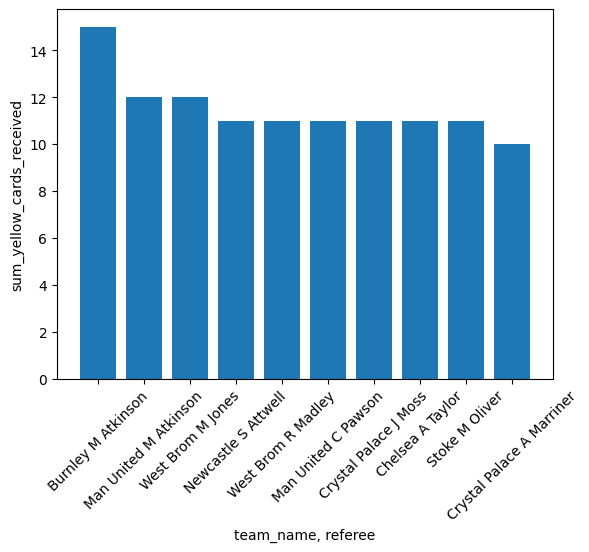

In [122]:
_.bar()

Following these results, we would highly encourage Burnley to play more conservatively and encourage their players not to make strong tackles in games where Martin Atkinson is the referee in the future. We also recommend that Man United spend additional time on defensive tackling drills since they appeared twice in the top ten teams to receive yellow cards from the same referee, with Martin Atkinson handing out 15 yellow cards to them and Craig Pawson handing them 11 yellow cards.

In this same season, Man United finished with 81 points which was 19 fewer than the league champions Man City, who finished with 100 points. Man City did not appear in this table at all so we would argue that these yellow cards may have an influence on points earned overall.

In [123]:
We will conduct some additional analysis to see which teams 

SyntaxError: invalid syntax (1242560403.py, line 1)

In [ ]:
%%sql
SELECT t.team_name, r.referee,
    sum(match_event_count) sum_fouls_committed
FROM Team T, Season S, Match_Events M, Games G, Game R
WHERE
    m.match_event = 'Fouls Committed' and
    s.key = g.season_key and
    t.key = g.team_key and
    m.key = g.match_event_key and
    r.key = g.game_key
GROUP BY r.referee, g.match_event_key, t.team_name
ORDER BY sum_fouls_committed DESC
LIMIT 10;